In [2]:
import cmaps

import pandas as pd 
import numpy as np
import xarray as xr

import cftime 
import nc_time_axis

from shapely import geometry
from scipy import signal, stats
import cartopy.feature as cfeature

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

import seaborn as sns 
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
                   
from src import precip, utils, nino34, dmi

from concurrent.futures import ProcessPoolExecutor

import random
random.seed(541415)

%load_ext autoreload
%autoreload 2

In [3]:
num_samples=10000

In [4]:
# List of CESM2 Ensemble Members
members = ['LE2-1001.001', 'LE2-1011.001', 'LE2-1021.002', 'LE2-1031.002', 'LE2-1041.003', 'LE2-1051.003',
            'LE2-1061.004', 'LE2-1071.004', 'LE2-1081.005', 'LE2-1091.005', 'LE2-1101.006', 'LE2-1111.006',
            'LE2-1121.007', 'LE2-1131.007', 'LE2-1141.008', 'LE2-1151.008', 'LE2-1161.009', 'LE2-1171.009',
            'LE2-1181.010', 'LE2-1191.010', 
            'LE2-1231.001', 'LE2-1231.002', 'LE2-1231.003', 'LE2-1231.004',
            'LE2-1231.005', 'LE2-1231.006', 'LE2-1231.007', 'LE2-1231.008', 'LE2-1231.009', 'LE2-1231.010',
            'LE2-1231.011', 'LE2-1231.012', 'LE2-1231.013', 'LE2-1231.014', 'LE2-1231.015', 'LE2-1231.016',
            'LE2-1231.017', 'LE2-1231.018', 'LE2-1231.019', 'LE2-1231.020',
            'LE2-1251.001', 'LE2-1251.002', 'LE2-1251.003', 'LE2-1251.004',
            'LE2-1251.005', 'LE2-1251.006', 'LE2-1251.007', 'LE2-1251.008', 'LE2-1251.009', 'LE2-1251.010',
            'LE2-1251.011', 'LE2-1251.012', 'LE2-1251.013', 'LE2-1251.014', 'LE2-1251.015', 'LE2-1251.016',
            'LE2-1251.017', 'LE2-1251.018', 'LE2-1251.019', 'LE2-1251.020',
            'LE2-1301.001', 'LE2-1301.002', 'LE2-1301.003', 'LE2-1301.004', 'LE2-1301.005', 'LE2-1301.006',
            'LE2-1301.007', 'LE2-1301.008', 'LE2-1301.009', 'LE2-1301.010', 'LE2-1301.011', 'LE2-1301.012', 
            'LE2-1301.013', 'LE2-1301.014', 'LE2-1301.015', 'LE2-1301.016', 'LE2-1301.017', 'LE2-1301.018',
            'LE2-1301.019', 'LE2-1301.020',
            'LE2-1281.001', 'LE2-1281.002', 'LE2-1281.003', 'LE2-1281.004', 'LE2-1281.005', 'LE2-1281.006',
            'LE2-1281.007', 'LE2-1281.008', 'LE2-1281.009', 'LE2-1281.010', 'LE2-1281.011', 'LE2-1281.012',
            'LE2-1281.013', 'LE2-1281.014', 'LE2-1281.015', 'LE2-1281.016', 'LE2-1281.017', 'LE2-1281.018',
            'LE2-1281.019', 'LE2-1281.020']

In [5]:
def process_member(ens):
    sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.global.1900_2100.nc")
    return sst_da
    
def main(members):
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        sst_anm = result
        all_ssts.append(sst_anm)
    return all_ssts

global_all_ssts_DJF = main(members)

In [6]:
def process_member(ens):
    #print(f"Processing {ens}")
    sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.global.MAM.1900_2100.nc")
    return sst_da
    
def main(members):
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        sst_anm = result
        all_ssts.append(sst_anm)
    return all_ssts

global_all_ssts_MAM = main(members)

In [7]:
def process_member(ens):
    da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.PRECT.msea.MAM.1900_2100.nc")
    return da
    
def main(members):
    all_da = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        all_da.append(result)
    return all_da

global_all_prect_MAM = main(members)

In [8]:
def process_member(ens):
    da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.TMQ.MAM.1900_2100.nc")
    return da
    
def main(members):
    all_da = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        all_da.append(result)
    return all_da

global_all_tmq_MAM = main(members)

In [9]:
def process_member(ens):
    #print(f"Processing {ens}")
    da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.OMEGA.tropics.DJF.1900_2100.nc")
    return da
    
def main(members):
    all_das = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        all_das.append(result)
    return all_das

global_all_omega_DJF = main(members)

In [10]:
def process_member(ens):
    #print(f"Processing {ens}")
    da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.Q850.DJF.1900_2100.nc")
    return da
    
def main(members):
    all_das = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        all_das.append(result)
    return all_das

global_all_Q850_DJF = main(members)

In [11]:
def process_member(ens):
    #print(f"Processing {ens}")
    da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.Q850.MAM.1900_2100.nc")
    return da
    
def main(members):
    all_das = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        all_das.append(result)
    return all_das

global_all_Q850_MAM = main(members)

In [12]:
def process_member(ens):
    #print(f"Processing {ens}")
    da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.Q.cropped.MAM.1900_2014.nc")
    return da
    
def main(members):
    all_das = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        all_das.append(result)
    return all_das

global_all_Qcropped_MAM = main(members)

In [13]:
def process_member(ens):
    #print(f"Processing {ens}")
    da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.U.cropped.MAM.1900_2014.nc")
    return da
    
def main(members):
    all_das = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        all_das.append(result)
    return all_das

global_all_Ucropped_MAM = main(members)

In [14]:
def process_member(ens):
    #print(f"Processing {ens}")
    da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.V.cropped.MAM.1900_2014.nc")
    return da
    
def main(members):
    all_das = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        all_das.append(result)
    return all_das

global_all_Vcropped_MAM = main(members)

In [15]:
def process_member(ens):
    #print(f"Processing {ens}")
    da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.U850.DJF.1900_2100.nc")
    return da
    
def main(members):
    all_das = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        all_das.append(result)
    return all_das

global_all_U850_DJF = main(members)

In [16]:
def process_member(ens):
    #print(f"Processing {ens}")
    da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.U850.MAM.1900_2100.nc")
    return da
    
def main(members):
    all_das = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        all_das.append(result)
    return all_das

global_all_U850_MAM = main(members)

In [17]:
def process_member(ens):
    #print(f"Processing {ens}")
    da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.V850.DJF.1900_2100.nc")
    return da
    
def main(members):
    all_das = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        all_das.append(result)
    return all_das

global_all_V850_DJF = main(members)

In [18]:
def process_member(ens):
    #print(f"Processing {ens}")
    da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.V850.MAM.1900_2100.nc")
    return da
    
def main(members):
    all_das = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        all_das.append(result)
    return all_das

global_all_V850_MAM = main(members)

In [19]:
global_ssts_ds_DJF = xr.concat(global_all_ssts_DJF, dim='ensemble')
global_ssts_ds_MAM = xr.concat(global_all_ssts_MAM, dim='ensemble')

In [20]:
global_prect_ds_MAM = xr.concat(global_all_prect_MAM, dim='ensemble')

In [21]:

global_tmq_ds_MAM = xr.concat(global_all_tmq_MAM, dim='ensemble')

In [22]:
global_tmq_ds_MAM['TMQ']

<xarray.DataArray 'TMQ' (ensemble: 100, time: 201, lat: 192, lon: 288)>
array([[[[0.41400647, 0.41400647, 0.41400647, ..., 0.41400647,
          0.41400647, 0.41400647],
         [0.43061432, 0.42959788, 0.42852417, ..., 0.43375158,
          0.4326954 , 0.43164673],
         [0.4558849 , 0.45353058, 0.4511536 , ..., 0.46284762,
          0.46053663, 0.458217  ],
         ...,
         [3.6225903 , 3.627021  , 3.631767  , ..., 3.6124496 ,
          3.6153042 , 3.6186066 ],
         [3.6869924 , 3.6890094 , 3.6908762 , ..., 3.681732  ,
          3.6833622 , 3.6851244 ],
         [3.7732422 , 3.7732422 , 3.7732422 , ..., 3.7732418 ,
          3.7732418 , 3.773242  ]],

        [[0.47949573, 0.47949573, 0.47949573, ..., 0.47949573,
          0.47949573, 0.47949573],
         [0.48864356, 0.48764905, 0.4865923 , ..., 0.49152923,
          0.49060273, 0.48961127],
         [0.5012928 , 0.4993225 , 0.4973421 , ..., 0.50723773,
          0.5052455 , 0.5032551 ],
...
         [7.251118  , 7.2537246 , 7.2560964 , ..., 7.2430854 ,
          7.245865  , 7.248554  ],
         [7.095609  , 7.0963326 , 7.097496  , ..., 7.0922923 ,
          7.0933266 , 7.0942574 ],
         [6.923719  , 6.92372   , 6.923712  , ..., 6.923715  ,
          6.9237237 , 6.9237213 ]],

        [[0.8256293 , 0.82562876, 0.82562906, ..., 0.8256292 ,
          0.8256283 , 0.8256292 ],
         [0.8683434 , 0.86618775, 0.86395377, ..., 0.87472606,
          0.87260777, 0.87044483],
         [0.91906184, 0.914202  , 0.90928453, ..., 0.93334246,
          0.92862993, 0.9238592 ],
         ...,
         [6.414946  , 6.4162407 , 6.4172225 , ..., 6.407881  ,
          6.410971  , 6.4133306 ],
         [6.380741  , 6.3833137 , 6.385035  , ..., 6.372141  ,
          6.3744063 , 6.377319  ],
         [6.4123063 , 6.4122615 , 6.4123063 , ..., 6.412288  ,
          6.4123054 , 6.4123015 ]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1900-12-31 00:00:00 ... 2100-12-31 00:00:00
Dimensions without coordinates: ensemble
Attributes:
    units:         kg/m2
    long_name:     Total (vertically integrated) precipitable water
    cell_methods:  time: mean

In [23]:
global_U850_ds_DJF = xr.concat(global_all_U850_DJF, dim='ensemble')
global_V850_ds_DJF = xr.concat(global_all_V850_DJF, dim='ensemble')

global_U850_ds_MAM = xr.concat(global_all_U850_MAM, dim='ensemble')
global_V850_ds_MAM = xr.concat(global_all_V850_MAM, dim='ensemble')

In [24]:
global_Q850_ds_DJF = xr.concat(global_all_Q850_DJF, dim='ensemble')
global_Q850_ds_MAM = xr.concat(global_all_Q850_MAM, dim='ensemble')

In [25]:
global_Qcropped_ds_MAM = xr.concat(global_all_Qcropped_MAM, dim='ensemble')
global_Ucropped_ds_MAM = xr.concat(global_all_Ucropped_MAM, dim='ensemble')
global_Vcropped_ds_MAM = xr.concat(global_all_Vcropped_MAM, dim='ensemble')


In [26]:
global_omega_ds_DJF = xr.concat(global_all_omega_DJF, dim='ensemble')


In [27]:
# Functions to calculate tropical interbasin interaction index

def _get_interbasin_areas_modified(da: xr.DataArray):
    """IO = wIOD area, IP = eIOD area, WP = nino3 area 

    """

    utils.check_data_conventions(da)

    # wIOD region
    area1 = da.sel(lat=slice(-10, 10), lon=slice(50, 70))

    # original MC region
    area2 = da.sel(lat=slice(-20, 20), lon=slice(100, 125))

    # Nino4 region
    area3 = da.sel(lat=slice(-5, 5), lon=slice(160, 210)) #160°E–150°W

    return area1, area2, area3


def _apply_interbasin_formula(SSTA_area1, SSTA_area2, SSTA_area3):
    """Calculate the unfiltered interbasin index from SST anomalies in each of
    the three interbasin regions using the interbasin formula.

    Args:

        # tropial west Indian Ocean: 40–80°E, -5°S–5°N)
        SSTA_area1 (xr.DataArray): SSTAs in region 1 (5°S-5°N, 40°E-80°E)
        
        # Central: 100–125°E, -20°S–20°N)
        SSTA_area2 (xr.DataArray): SSTAs in region 2 (20°S-20°N, 100°E-125°E)
        
        #Western Pacific: 5S-5N and 140E-180W
        SSTA_area3 (xr.DataArray): SSTAs in region 3 (5°S-5°N, 140°E-180°E)

    Returns:
        TPI_idx: SSTA_area2 - ((SSTA_area1 + SST_Aarea3)/2)

    """

    a1a3 = SSTA_area1+SSTA_area3
    div2 = a1a3/2.0
    unfilt_interbasin_idx = div2-SSTA_area2

    return unfilt_interbasin_idx


def _apply_cheby1_filter(da: xr.DataArray, period=13*1, btype='lowpass', n=6.0,
                        rp=0.1, fs=None):
    """Apply a Chebyshev type I digital filter to monthly timeseries data.

    Default filter design values are from Henley et al. 2015 (i.e. 13-year
    low-pass filter with period 6 for the TPI Index).

    This function was originally copied from Sonya Wellby's github repo:
    https://github.com/sonyawellby/anu_honours/blob/master/tpi.py
    but I think her comments on the default filter parameters are wrong
    (rp is not 13 and wn is not 0.1).

    Args:
        da (xr.DataArray): monthly timeseries data to be filtered
        period (float, default: 13*12): period of the filter in months
        n (float, default: 6): the order of the filter,
        rp (float, default: 0.1): the peak to peak passband ripple (in decibles)
        fs (bool, default: False): the sampling frequency of the system
                             default = False

    Returns:
        da_filt (xr.DataArray): filtered monthly timeseries data

    """

    wn = 1/(period*0.5)    # critical frequencies --> half-cycles / sample
    b, a = signal.cheby1(n, rp, wn, btype=btype, analog=False,
                         output='ba', fs=fs)
    
    # Convert numpy.ndarray 'nda_filt' to an xr.DataArray
    if 'ensemble' in da.dims:
        nda_filt = signal.filtfilt(b, a, da.values, axis=1)  # output is a filtered numpy.ndarray
        da_filt = xr.DataArray(nda_filt, dims=('ensemble', 'time'), coords={'time': da.coords['time']})
    else:
        nda_filt = signal.filtfilt(b, a, da.values, axis=0)  # output is a filtered numpy.ndarray
        da_filt = xr.DataArray(nda_filt, dims=('time'), coords={'time': da.coords['time']})

    return da_filt


def get_interbasin_timeseries_modified(sst_da: xr.DataArray, detrend: bool,
                          base_start: str, base_end: str,
                          filtered=True):

    """Get the timeseries of the TPI index from SST data.

    Note that the climatological period is the entire time period spanned by
    the input sst data. Must specify option to remove the linear trend.
    Default filtering is a 13-year low pass Chebyshev filter.

    Args:
        sst_da (xr.DataArray): monthly SST data array
        linear_detrend (bool, default: True): if True, remove linear trend
        filtered (bool, default: True): if True, apply 13-year lowpass filter

    Returns:
        interbasin_idx (xr.DataArray): timeseries of the interbasin index in units of
        temperature

    """

    # Detrend the data (optional)
    if detrend:

        # Detrend by removing timeseries of global mean SSTs
        global_mean_ssts = utils.calc_cos_wmean(sst_da)
        sst_da = sst_da-global_mean_ssts

        # Detrend by removing linear trend (does not work for IOB)
        # sst_da = utils.detrend_array(sst_da, "time", 1)

    # Calculate SST anomalies by removing monthly climatology
    # (default climatological period is the entire data period)
    da_anm = utils.remove_monthly_clm(sst_da, base_start, base_end)

    # Get slice of SST anomalies for each interbasin region
    anm1, anm2, anm3 = _get_interbasin_areas_modified(da_anm)

    # Take area-weighted averaged of each region
    mean1 = utils.calc_cos_wmean(anm1)
    mean2 = utils.calc_cos_wmean(anm2)
    mean3 = utils.calc_cos_wmean(anm3)

    # Calculate interbasin index
    interbasin_idx = _apply_interbasin_formula(mean1, mean2, mean3)
    
    # Apply 13-year Chebyshev filter (optional)
    if filtered is True:
        #interbasin_idx = interbasin_idx.rolling(time=13, center=True).mean()
        #mean1 = mean1.rolling(time=13, center=True).mean()
        #mean2 = mean2.rolling(time=13, center=True).mean()
        #mean3 = mean3.rolling(time=13, center=True).mean()

        interbasin_idx = _apply_cheby1_filter(interbasin_idx)
        #mean1 = _apply_cheby1_filter(mean1)
        #mean2 = _apply_cheby1_filter(mean2)
        #mean3 = _apply_cheby1_filter(mean3)

    return interbasin_idx

In [28]:
global_U850_da_DJF = global_U850_ds_DJF['U'].sel(time=slice('1900-01','2100-12'))
global_V850_da_DJF = global_V850_ds_DJF['V'].sel(time=slice('1900-01','2100-12'))

global_U850_da_MAM = global_U850_ds_MAM['U'].sel(time=slice('1900-01','2100-12'))
global_V850_da_MAM = global_V850_ds_MAM['V'].sel(time=slice('1900-01','2100-12'))


In [29]:
global_Q850_da_DJF = global_Q850_ds_DJF['Q'].sel(time=slice('1900-01','2100-12'))
global_Q850_da_MAM = global_Q850_ds_MAM['Q'].sel(time=slice('1900-01','2100-12'))


In [30]:
global_Qcropped_da_MAM = global_Qcropped_ds_MAM['Q']
global_Ucropped_da_MAM = global_Ucropped_ds_MAM['U']
global_Vcropped_da_MAM = global_Vcropped_ds_MAM['V']


In [31]:
# Get TTP Index
global_ssts_da_DJF = global_ssts_ds_DJF['SST'].isel(z_t=0, drop=True).sel(time=slice('1900-01','2100-12'))
global_ssts_da_MAM = global_ssts_ds_MAM['SST'].isel(z_t=0, drop=True).sel(time=slice('1900-01','2100-12'))

global_omega_da_DJF = global_omega_ds_DJF['OMEGA'].sel(time=slice('1900-01','2100-12'))

interbasin_idx = get_interbasin_timeseries_modified(global_ssts_da_DJF, detrend=False,
                          base_start='1951-01', base_end='2015-12',
                          filtered=True)

In [32]:
global_prect_da_MAM = global_prect_ds_MAM['PRECT'].sel(time=slice('1900-01','2100-12'))
global_tmq_da_MAM = global_tmq_ds_MAM['TMQ'].sel(time=slice('1900-01','2100-12'))

In [33]:
def convert_to_mm_per_month(group):
    # Convert m/s to mm/month 
    month = group.time.dt.month[0].item()  # Get the month number from the first item of the group
    
    # Seconds per month (non-leap years in CESM calendar)
    seconds_per_month = {
        1: 31 * 24 * 60 * 60,  # January
        2: 28 * 24 * 60 * 60,  # February (non-leap year)
        3: 31 * 24 * 60 * 60,  # March
        4: 30 * 24 * 60 * 60,  # April
        5: 31 * 24 * 60 * 60,  # May
        6: 30 * 24 * 60 * 60,  # June
        7: 31 * 24 * 60 * 60,  # July
        8: 31 * 24 * 60 * 60,  # August
        9: 30 * 24 * 60 * 60,  # September
        10: 31 * 24 * 60 * 60,  # October
        11: 30 * 24 * 60 * 60,  # November
        12: 31 * 24 * 60 * 60   # December
    }
    return group * 1000 * seconds_per_month[month]

In [34]:
global_prect_da_MAM = global_prect_da_MAM.groupby('time.month').map(convert_to_mm_per_month)

In [35]:
import numpy as np
import pandas as pd
import xarray as xr

index = interbasin_idx.sel(time=slice('1900','2014'))

# Initialize lists to store results
positive_ensembles = []
positive_time_starts = []
negative_ensembles = []
negative_time_starts = []

# Number of ensembles and time steps
num_ensembles = index.sizes['ensemble']
num_time_steps = index.sizes['time']
period_length = 13

# Loop over each ensemble member
for ensemble in range(num_ensembles):
    data = index.isel(ensemble=ensemble).values  # Extract data for the ensemble member
    
    # Loop over possible starting points for the 13-year period
    for t in range(num_time_steps - period_length + 1):
        period = data[t:t+period_length]
        
        # Check if all values in the period are positive
        if np.all(period > 0):
            positive_ensembles.append(ensemble)
            positive_time_starts.append(index.coords['time'][t].dt.year.values)
        # Check if all values in the period are negative
        elif np.all(period < 0):
            negative_ensembles.append(ensemble)
            negative_time_starts.append(index.coords['time'][t].dt.year.values)

# Create DataFrames from the results
df_positive = pd.DataFrame({
    'ensemble': positive_ensembles,
    'year_start': positive_time_starts
})

df_negative = pd.DataFrame({
    'ensemble': negative_ensembles,
    'year_start': negative_time_starts
})

# Display the DataFrames
print("Positive Phases:")
print(df_positive)
print("Negative Phases:")
print(df_negative)

Positive Phases:
     ensemble year_start
0           0       1981
1           0       1982
2           0       1983
3           0       1984
4           0       1985
..        ...        ...
749        98       1962
750        98       1963
751        98       1964
752        98       1965
753        99       1969

[754 rows x 2 columns]
Negative Phases:
      ensemble year_start
0            0       1904
1            0       1905
2            0       1906
3            0       1907
4            0       1908
...        ...        ...
1054        99       1926
1055        99       1927
1056        99       1928
1057        99       1929
1058        99       1930

[1059 rows x 2 columns]


In [36]:
num_rows_pos = df_positive.shape[0]
num_rows_neg = df_negative.shape[0]

random_ensembles_pos = np.random.randint(0, 100, size=num_rows_pos)
random_ensembles_neg = np.random.randint(0, 100, size=num_rows_neg)

random_year_starts_pos = np.random.randint(1900, 2012, size=num_rows_pos)
random_year_starts_neg = np.random.randint(1900, 2012, size=num_rows_neg)

df_pos_random = pd.DataFrame({
    'ensemble': random_ensembles_pos,
    'year_start': random_year_starts_pos
})

df_neg_random = pd.DataFrame({
    'ensemble': random_ensembles_neg,
    'year_start': random_year_starts_neg
})



In [37]:
# For each of the three categories: positive correlations, negative correlations, and random, 
# select global SST slices and OMEGA slices

def get_slices(da):
    
    pos_slices = []
    for index, row in df_positive.iterrows():
        my_ens = row['ensemble']
        my_year = row['year_start']

        ens_da = da.sel(ensemble=my_ens)
        my_slice = ens_da.sel(time=slice(str(int(my_year)), str(int(my_year)+13))).mean(dim='time')
        pos_slices.append(my_slice)

    neg_slices = []
    for index, row in df_negative.iterrows():
        my_ens = row['ensemble']
        my_year = row['year_start']

        ens_da = da.sel(ensemble=my_ens)
        my_slice = ens_da.sel(time=slice(str(int(my_year)), str(int(my_year)+13))).mean(dim='time')
        neg_slices.append(my_slice)

    pos_random_slices = []
    for index, row in df_pos_random.iterrows():
        my_ens = row['ensemble']
        my_year = row['year_start']

        ens_da = da.sel(ensemble=my_ens)
        my_slice = ens_da.sel(time=slice(str(int(my_year)), str(int(my_year)+13))).mean(dim='time')
        pos_random_slices.append(my_slice)

    neg_random_slices = []
    for index, row in df_neg_random.iterrows():
        my_ens = row['ensemble']
        my_year = row['year_start']

        ens_da = da.sel(ensemble=my_ens)
        my_slice = ens_da.sel(time=slice(str(int(my_year)), str(int(my_year)+13))).mean(dim='time')
        neg_random_slices.append(my_slice)

    pos_slices_da = xr.concat(pos_slices, dim='random')
    neg_slices_da = xr.concat(neg_slices, dim='random')
    pos_random_slices_da = xr.concat(pos_random_slices, dim='random')
    neg_random_slices_da = xr.concat(neg_random_slices, dim='random')

    return pos_slices_da, neg_slices_da, pos_random_slices_da, neg_random_slices_da

In [38]:
from statsmodels.stats.multitest import multipletests

def correct_pvals(p_val, alpha_global, method='fdr=bh'):

    p_values = p_val

    # Flatten array and remove NaNs
    p_values_flat = p_values.flatten()
    non_nan_mask = ~np.isnan(p_values_flat)
    non_nan_pvals = p_values_flat[non_nan_mask]

    # Apply the Benjamini-Hochberg correction
    _, corrected_pvals, _, _ = multipletests(non_nan_pvals, alpha=alpha_global, method=method)

    # Place corrected p-values back into the original array, keeping NaNs intact
    corrected_p_values = np.full_like(p_values_flat, np.nan)
    corrected_p_values[non_nan_mask] = corrected_pvals

    # Reshape back to the original shape
    corrected_p_values = corrected_p_values.reshape(p_values.shape)

    return corrected_p_values

In [39]:
def get_data_and_pvals(data, random_data):
    my_data = data.mean(dim='random') - random_data.mean(dim=['random'])
    tstat, pval = stats.ttest_ind(data, random_data, equal_var=False)
    my_pval = correct_pvals(pval, alpha_global=0.002, method='fdr_bh')
    return my_data, my_pval

In [40]:
global_ssts_da_DJF_present = global_ssts_da_DJF.sel(time=slice('1900','2014'))
global_U850_da_DJF_present = global_U850_da_DJF.sel(time=slice('1900','2014'))
global_V850_da_DJF_present = global_V850_da_DJF.sel(time=slice('1900','2014'))

global_U850_da_MAM_present = global_U850_da_MAM.sel(time=slice('1900','2014'))
global_V850_da_MAM_present = global_V850_da_MAM.sel(time=slice('1900','2014'))
global_Q850_da_MAM_present = global_Q850_da_MAM.sel(time=slice('1900','2014'))

global_omega_da_DJF_present = global_omega_da_DJF.sel(time=slice('1900','2014'))

In [41]:
global_prect_da_MAM_present = global_prect_da_MAM.sel(time=slice('1900','2014'))
global_tmq_da_MAM_present = global_tmq_da_MAM.sel(time=slice('1900','2014'))

In [42]:
sst_pos_slices_da, sst_neg_slices_da, sst_pos_random_slices_da, sst_neg_random_slices_da = get_slices(global_ssts_da_DJF_present)
u_pos_slices_da, u_neg_slices_da, u_pos_random_slices_da, u_neg_random_slices_da = get_slices(global_U850_da_DJF_present)
v_pos_slices_da, v_neg_slices_da, v_pos_random_slices_da, v_neg_random_slices_da = get_slices(global_V850_da_DJF_present)
o_pos_slices_da, o_neg_slices_da, o_pos_random_slices_da, o_neg_random_slices_da = get_slices(global_omega_da_DJF_present)

u_pos_slices_da_mam, u_neg_slices_da_mam, u_pos_random_slices_da_mam, u_neg_random_slices_da_mam = get_slices(global_U850_da_MAM_present)
v_pos_slices_da_mam, v_neg_slices_da_mam, v_pos_random_slices_da_mam, v_neg_random_slices_da_mam = get_slices(global_V850_da_MAM_present)
q_pos_slices_da_mam, q_neg_slices_da_mam, q_pos_random_slices_da_mam, q_neg_random_slices_da_mam = get_slices(global_Q850_da_MAM_present)



In [43]:
u_pos_slices_da_mam3d, u_neg_slices_da_mam3d, u_pos_random_slices_da_mam3d, u_neg_random_slices_da_mam3d = get_slices(global_Ucropped_da_MAM)
v_pos_slices_da_mam3d, v_neg_slices_da_mam3d, v_pos_random_slices_da_mam3d, v_neg_random_slices_da_mam3d = get_slices(global_Vcropped_da_MAM)
q_pos_slices_da_mam3d, q_neg_slices_da_mam3d, q_pos_random_slices_da_mam3d, q_neg_random_slices_da_mam3d = get_slices(global_Qcropped_da_MAM)


In [44]:
u_pos_diff3d, u_pos_pval3d = get_data_and_pvals(u_pos_slices_da_mam3d, u_pos_random_slices_da_mam3d)
u_neg_diff3d, u_neg_pval3d = get_data_and_pvals(u_neg_slices_da_mam3d, u_neg_random_slices_da_mam3d)

v_pos_diff3d, v_pos_pval3d = get_data_and_pvals(v_pos_slices_da_mam3d, v_pos_random_slices_da_mam3d)
v_neg_diff3d, v_neg_pval3d = get_data_and_pvals(v_neg_slices_da_mam3d, v_neg_random_slices_da_mam3d)

q_pos_diff3d, q_pos_pval3d = get_data_and_pvals(q_pos_slices_da_mam3d, q_pos_random_slices_da_mam3d)
q_neg_diff3d, q_neg_pval3d = get_data_and_pvals(q_neg_slices_da_mam3d, q_neg_random_slices_da_mam3d)

In [45]:
p_pos_slices_da, p_neg_slices_da, p_pos_random_slices_da, p_neg_random_slices_da = get_slices(global_prect_da_MAM_present)
t_pos_slices_da, t_neg_slices_da, t_pos_random_slices_da, t_neg_random_slices_da = get_slices(global_tmq_da_MAM_present)


In [46]:
p_pos_slices_da_msea = p_pos_slices_da.sel(lat=slice(10,25), lon=slice(90,110)).mean(dim=['lat', 'lon'])
print(p_pos_slices_da_msea.std(dim='random'))

p_neg_slices_da_msea = p_neg_slices_da.sel(lat=slice(10,25), lon=slice(90,110)).mean(dim=['lat', 'lon'])
print(p_neg_slices_da_msea.std(dim='random'))

<xarray.DataArray 'PRECT' ()>
array(4.32294723)
<xarray.DataArray 'PRECT' ()>
array(5.04445331)


In [47]:
sst_pos_diff, sst_pos_pval = get_data_and_pvals(sst_pos_slices_da, sst_pos_random_slices_da)
sst_neg_diff, sst_neg_pval = get_data_and_pvals(sst_neg_slices_da, sst_neg_random_slices_da)

u_pos_diff, u_pos_pval = get_data_and_pvals(u_pos_slices_da, u_pos_random_slices_da)
u_neg_diff, u_neg_pval = get_data_and_pvals(u_neg_slices_da, u_neg_random_slices_da)

v_pos_diff, v_pos_pval = get_data_and_pvals(v_pos_slices_da, v_pos_random_slices_da)
v_neg_diff, v_neg_pval = get_data_and_pvals(v_neg_slices_da, v_neg_random_slices_da)

o_pos_diff, o_pos_pval = get_data_and_pvals(o_pos_slices_da, o_pos_random_slices_da)
o_neg_diff, o_neg_pval = get_data_and_pvals(o_neg_slices_da, o_neg_random_slices_da)

q_pos_diff, q_pos_pval = get_data_and_pvals(q_pos_slices_da_mam, q_pos_random_slices_da_mam)
q_neg_diff, q_neg_pval = get_data_and_pvals(q_neg_slices_da_mam, q_neg_random_slices_da_mam)


In [48]:
p_pos_diff, p_pos_pval = get_data_and_pvals(p_pos_slices_da, p_pos_random_slices_da)
p_neg_diff, p_neg_pval = get_data_and_pvals(p_neg_slices_da, p_neg_random_slices_da)

t_pos_diff, t_pos_pval = get_data_and_pvals(t_pos_slices_da, t_pos_random_slices_da)
t_neg_diff, t_neg_pval = get_data_and_pvals(t_neg_slices_da, t_neg_random_slices_da)


In [49]:
u_pos_diff_mam, u_pos_pval_mam = get_data_and_pvals(u_pos_slices_da_mam, u_pos_random_slices_da_mam)
u_neg_diff_mam, u_neg_pval_mam = get_data_and_pvals(u_neg_slices_da_mam, u_neg_random_slices_da_mam)

v_pos_diff_mam, v_pos_pval_mam = get_data_and_pvals(v_pos_slices_da_mam, v_pos_random_slices_da_mam)
v_neg_diff_mam, v_neg_pval_mam = get_data_and_pvals(v_neg_slices_da_mam, v_neg_random_slices_da_mam)

q_pos_diff_mam, q_pos_pval_mam = get_data_and_pvals(q_pos_slices_da_mam, q_pos_random_slices_da_mam)
q_neg_diff_mam, q_neg_pval_mam = get_data_and_pvals(q_neg_slices_da_mam, q_neg_random_slices_da_mam)


/tmp/ipykernel_1871591/3398517429.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1871591/3398517429.py:235: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("Fig3.png")
/tmp/ipykernel_1871591/3398517429.py:235: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("Fig3.png")
/tmp/ipykernel_1871591/3398517429.py:236: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("Fig3.pdf")
/tmp/ipykernel_1871591/3398517429.py:236: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("Fig3.pdf")
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/IPython/core/pyla

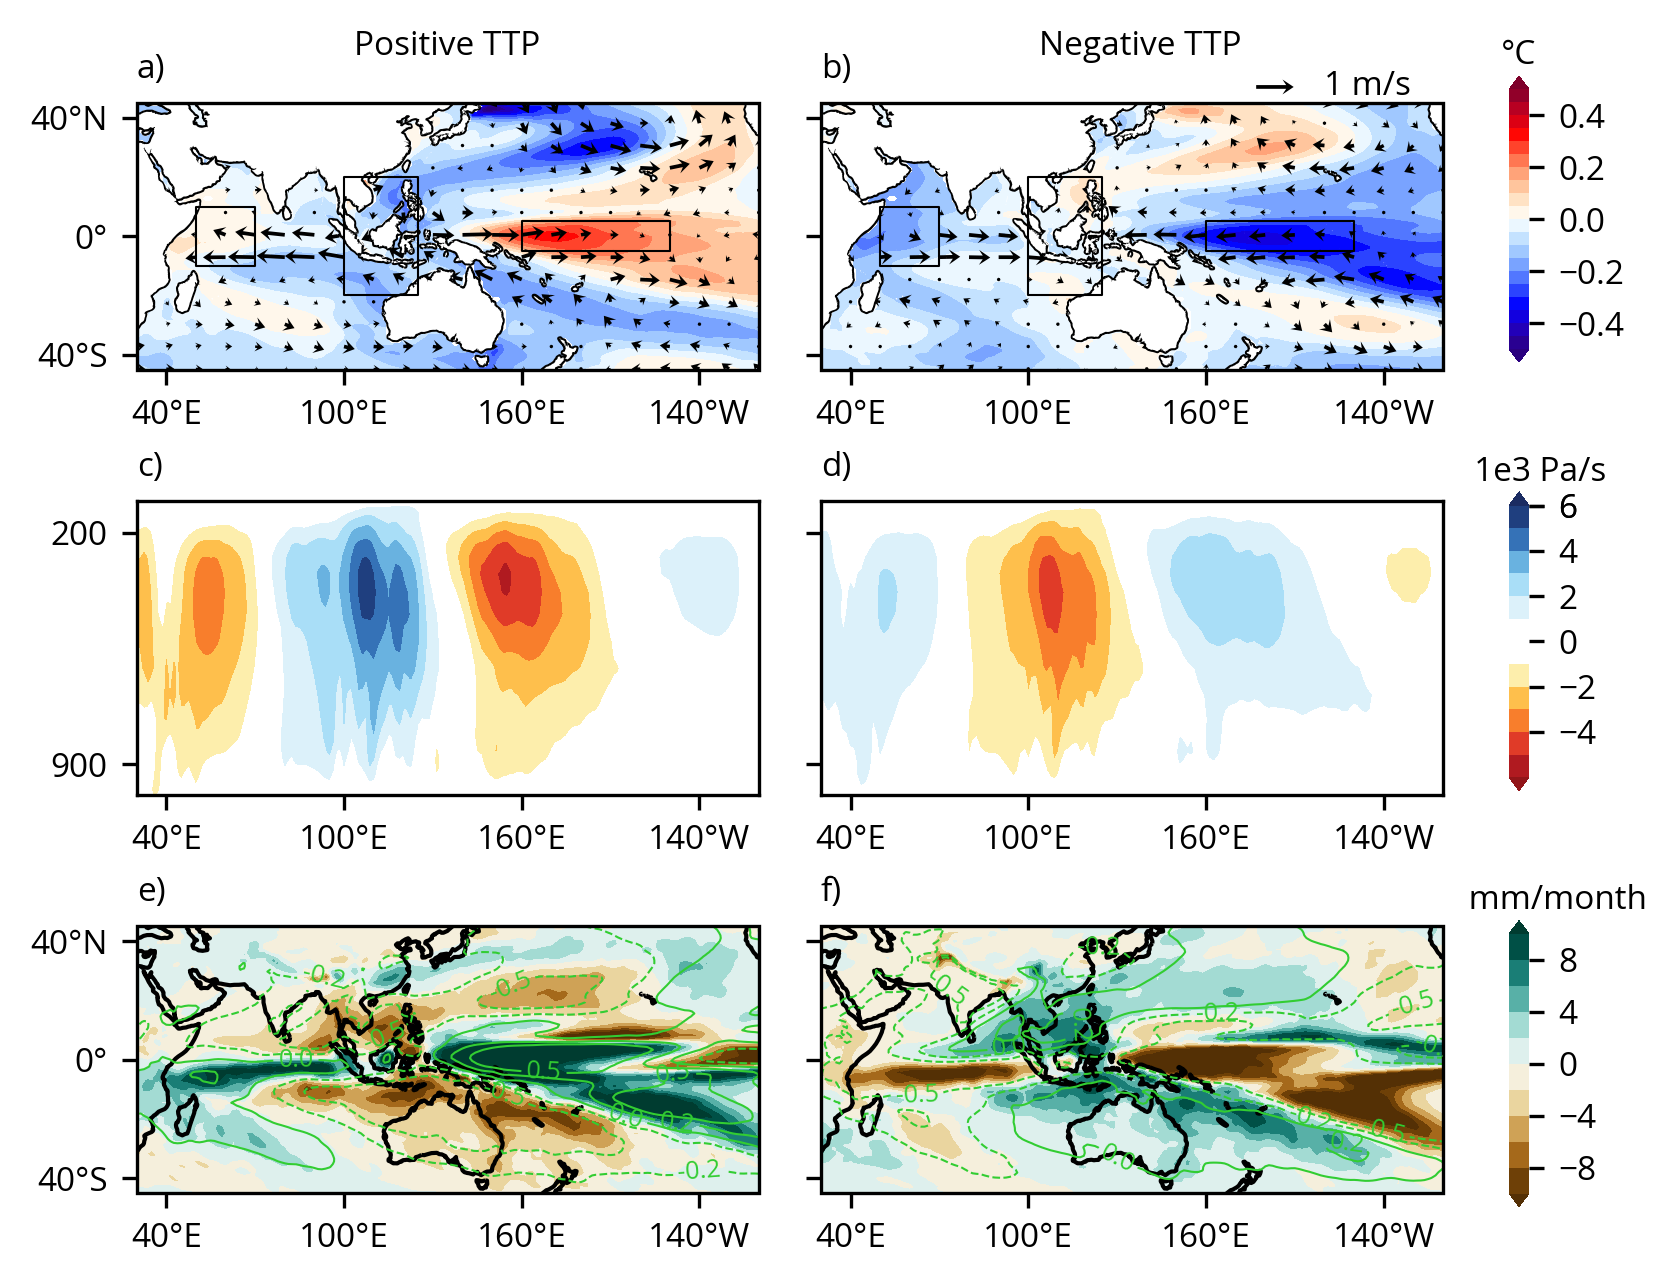

In [54]:
%matplotlib inline 

mpl.rcParams['hatch.linewidth'] = 0.3 

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()


utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 14
fig_height_cm = 11
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54


fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)
gs1 = GridSpec(3, 2,  top=0.93, bottom=0.07, left=0.08, right=0.87, hspace=0.4, wspace=0.1)
ax1 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(gs1[0, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax3 = fig.add_subplot(gs1[1, 0])
ax4 = fig.add_subplot(gs1[1, 1])
ax5 = fig.add_subplot(gs1[2, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax6 = fig.add_subplot(gs1[2, 1], projection=ccrs.PlateCarree(central_longitude=180))

############## Figure 3a ##############

sst_levels = [-.5, -.45, -.4, -.35, -.3, -.25, -.2, -.15, -.1, -0.05, 0, 0.05, .1,.15, .2, .25, .3, .35, .4, .45, .5]


im = ax1.contourf(sst_pos_diff.lon,
                sst_pos_diff.lat,
                sst_pos_diff,
                cmap=cmaps.NCV_blu_red,
                norm=mpl.colors.CenteredNorm(),
                transform=ccrs.PlateCarree(),
                extend="both",
                levels=sst_levels)

lon = u_pos_diff.lon
lat = u_pos_diff.lat
lon2d, lat2d = np.meshgrid(lon, lat)

skip = (slice(None, None, 8), slice(None, None, 8))  # Plot every other vector

q = ax1.quiver(
    lon2d[skip], lat2d[skip],
    u_pos_diff.values[skip],
    v_pos_diff.values[skip],
    transform=ccrs.PlateCarree(),
    scale=8,
    scale_units='inches',
    color='black',
    headwidth=4,       # Decrease the headwidth to make the arrowhead narrower
    headlength=3,      # Decrease the headlength to make the arrowhead shorter
    headaxislength=2,  # Adjust to control the arrowhead's length along the shaft
    width=0.006        # Adjust the shaft width as needed
)
#qk = ax1.quiverkey(q, X=0.06, Y=1.05, U=0.8, label='0.8 m/s', labelpos='E', fontproperties={'size': 6})
    

############## Figure 3b ##############
im = ax2.contourf(sst_neg_diff.lon,
                sst_neg_diff.lat,
                sst_neg_diff,
                cmap=cmaps.NCV_blu_red,
                norm=mpl.colors.CenteredNorm(),
                transform=ccrs.PlateCarree(),
                extend="both",
                levels=sst_levels)
                
q = ax2.quiver(
    lon2d[skip], lat2d[skip],
    u_neg_diff.values[skip],
    v_neg_diff.values[skip],
    transform=ccrs.PlateCarree(),
    scale=8,
    scale_units='inches',
    color='black',
    headwidth=4,       # Decrease the headwidth to make the arrowhead narrower
    headlength=3,      # Decrease the headlength to make the arrowhead shorter
    headaxislength=2,  # Adjust to control the arrowhead's length along the shaft
    width=0.006        # Adjust the shaft width as needed
)

qk = ax2.quiverkey(
    q, X=0.76, Y=1.06, U=1,
    label='1 m/s',
    labelpos='E',
    fontproperties={'size': 8}
)

for ax in [ax1, ax2, ax5, ax6]:
    ax.set_extent([30, 240, -45, 45], crs=ccrs.PlateCarree())
    ax.set_xticks([40, 100, 160, 220], crs=ccrs.PlateCarree())
    ax.set_xticklabels([40, 100, 160, 220], fontsize=8)
    ax.xaxis.set_major_formatter(lon_formatter)

for ax in [ax1, ax2, ax5, ax6]:
    ax.set_yticks([-40, 0, 40], crs=ccrs.PlateCarree())

ax1.yaxis.set_major_formatter(lat_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)


for ax in [ax2, ax6]:
    ax.set_yticklabels([-40, 0, 40], fontsize=8)
    ax.set_yticklabels([], fontsize=8)

######################################

# 3a and 3b colorbar
cbar_ax = fig.add_axes([0.91, 0.72, 0.012, 0.22])  # [left, bottom, width, height]
cbar = fig.colorbar(im,  cax=cbar_ax, ticks=[-0.4, -0.2, 0, 0.2, 0.4], orientation="vertical", shrink=0.50)
cbar.outline.set_visible(False)
cbar.ax.set_title('°C', fontsize=8)

############## Figure 3c ##############
ax3.invert_yaxis()

o_pos_diff = o_pos_diff.sel(lon=slice(30, 240), lev=slice(100,1000))
om = ax3.contourf(
    o_pos_diff.lon,o_pos_diff.lev,
    o_pos_diff*1e3,
    cmap=cmaps.BlueWhiteOrangeRed_r,
    norm=mpl.colors.CenteredNorm(),
    extend="both",
    levels=np.arange(-6,7,1)
)

############## Figure 3d ##############
ax4.invert_yaxis()

o_neg_diff = o_neg_diff.sel(lon=slice(30, 240), lev=slice(100,1000))
om = ax4.contourf(
    o_neg_diff.lon,o_neg_diff.lev,
    o_neg_diff*1e3,
    cmap=cmaps.BlueWhiteOrangeRed_r,
    norm=mpl.colors.CenteredNorm(),
    extend="both",
    levels=np.arange(-6,7,1)
)

#########################################
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

for ax in [ax3, ax4]:
    ax.set_xticks([40, 100, 160, 220], crs=ccrs.PlateCarree())
    ax.set_xticklabels(['40°E', '100°E', '160°E', '140°W'], fontsize=8)

for ax in [ax3, ax4]:
    ax.set_yticks([200, 900], crs=ccrs.PlateCarree())

ax3.set_yticklabels(['200', '900'], fontsize=8)
ax4.set_yticklabels([], fontsize=8)


######################################

# 3c and 3d colorbar
cbar_ax = fig.add_axes([0.91, 0.39, 0.012, 0.23])  # [left, bottom, width, height]
cbar = fig.colorbar(om,  cax=cbar_ax, ticks=[6, -4, -2, 0, 2, 4, 6], orientation="vertical", shrink=0.50)
cbar.outline.set_visible(False)
cbar.ax.set_title('     1e3 Pa/s', fontsize=8)

############## Figure 3e ##############

pc_levels = np.linspace(-10, 10, 11)

pc = ax5.contourf(lon, lat, p_pos_diff, levels=pc_levels,
                  transform=ccrs.PlateCarree(), cmap='BrBG', extend='both')

############## Figure 3f ##############
pc = ax6.contourf(lon, lat, p_neg_diff, levels=pc_levels,
                  transform=ccrs.PlateCarree(), cmap='BrBG', extend='both')

# 3e and 3f colorbar 
cbar_ax = fig.add_axes([0.91, 0.07, 0.012, 0.22])  # [left, bottom, width, height]
cbar = fig.colorbar(pc,  cax=cbar_ax, orientation="vertical", shrink=0.50)
cbar.outline.set_visible(False)
cbar.ax.set_title('         mm/month', fontsize=8)

mc_levels = [-0.5 , -0.25,  0.  ,  0.25,  0.5 ]

mc = ax5.contour(t_pos_diff.lon, t_pos_diff.lat, t_pos_diff, levels=mc_levels,
                 transform=ccrs.PlateCarree(), colors='limegreen', linewidths=0.5)
ax5.clabel(mc, inline=True, fontsize=6, fmt='%1.1f', colors='limegreen')

mc = ax6.contour(t_neg_diff.lon, t_neg_diff.lat, t_neg_diff, levels=mc_levels,
                 transform=ccrs.PlateCarree(), colors='limegreen', linewidths=0.5)
ax6.clabel(mc, inline=True, fontsize=6, fmt='%1.1f', colors='limegreen')

# Add a land mask
land_mask = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='none', facecolor='white')

for ax in [ax1, ax2]:
    ax.coastlines(linewidth=1)
    ax.add_feature(land_mask)
    
    # tropial west Indian Ocean: 40–80°E, -5°S–5°N)
    geom = geometry.box(minx=50, maxx=70, miny=-10, maxy=10)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=0.5)

    # Central: 100–125°E, -20°S–20°N)
    geom = geometry.box(minx=100, maxx=125, miny=-20, maxy=20)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=0.5)

    # Western Pacific: 5S-5N and 140E-180W.
    geom = geometry.box(minx=160, maxx=210, miny=-5, maxy=5)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='k', facecolor='none', linewidth=0.5)

for ax in [ax5, ax6]:
    ax.coastlines(linewidth=1)
    
# Set subplot labels
titles = ["a)", "b)", "c)", "d)", "e)", "f)"]
for i, (ax, title) in enumerate(zip([ax1, ax2, ax3, ax4, ax5, ax6], titles)):
    ax.set_title(title, loc="left", fontsize=8)

ax1.text(0.35, 1.18, f'Positive TTP', color='black', fontsize=8, transform=ax1.transAxes)
ax2.text(0.35, 1.18, f'Negative TTP', color='black', fontsize=8, transform=ax2.transAxes)

plt.tight_layout()
plt.savefig("Fig3.png")
plt.savefig("Fig3.pdf")
